# 06. PyTorch Transfer Learning 

What is transfer learning?

Transfer learning involves taking the parameters of what one model has
learned on another dataset and applying to our own problem.

* Pretrained model = foundation models

In [ ]:
import torch
import torchvision

print(f"PyTorch Version : {torch.__version__}") #want 0.12+
print(f"Torchvision version : {torchvision.__version__}") # want 0.13+

PyTorch Version : 1.13.1+cu116
Torchvision version : 0.14.1+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/Prakashdey497/PyTorch.git
    !mv PyTorch/going_modular .
    !rm -rf PyTorch
    from going_modular import data_setup, engine

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

We need our pizza,steak,sushi data to build a transfer learning model on.


In [ ]:
import os
import zipfile

from pathlib import Path
import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it..
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  
  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
      request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
      print("Downloading pizza, steak, sushi data...")
      f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi data...") 
      zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


data/pizza_steak_sushi directory exists, skipping re-download.


In [ ]:
# Setup directory path
train_dir = image_path/"train"
test_dir = image_path/"test"

## 2. Create Datasets and DataLoaders

Now we've got some data,want to turn it into PyTorch dataloaders.

To do so we can use `data_setup.py` and the `create_dataloader.py`.

Before Dataloader we need to transform it. In `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms- you define what transforms we want our data to go through.

2. Automatically created transforms: The transforms for your data are defined by the model you'd like to use.

**Note :** when using a pretrained model, it's importent that the data (including our custom data) that we pass through it is transformed in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models`(manual creation)

`torchvision.models` contains pretrained models(model ready for tranfer learning) right within `torchvision`.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
from torchvision.transforms.functional import normalize
from torchvision import transforms

normalize = transforms.Normalize( mean=[0.485,0.456,0.406],
                                  std=[0.229,0.224,0.225])

manual_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize])

In [ ]:
from going_modular import data_setup

train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(
                                  train_dir= train_dir,
                                  test_dir = test_dir,
                                  transform=manual_transform,
                                  batch_size=32)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f7975849ca0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various laces to get a pretrained model, such as:

1. PyTorch domain libraries

2. Libraries like timm(torch image models)

3. HuggingFace Hub(for plenty of different models)

4. Paperswithcode(for model across different problem spaces/domains)

## 3.1 Which pretrained model should we use?

Three things to consider:

1. Speed - How fast does it run?

2. Size - how big is the model?

3. Performance - how well does it go on your chosen problem(e.g. how well does it classify food images? for foodvision Mini)?

Which model should we use?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0
is one of our best options in terms perfomance vs size.

However, In light of the Bitter lesson,if we had infinite compute,we'd likely pick the biggest model + most parameters + most general we could- http://www.incompleteideas.net/IncIdeas/BitterLesson.html

In [ ]:
# Old method of creating a parameter model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model(torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size = (1,3,224,224),
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model,typically we will **freeze** the base layer of a pretrained/foundation model and update the output layers to suit our own problem.

In [ ]:
# Freez all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
# Update the classifier head of our model to suit our problem

from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features= 1280,
              out_features= len(class_names))

).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model=model,
        input_size = (1,3,224,224),
        col_names = ["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [ ]:
# Define loss and Optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

In [ ]:
# Import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(128)
torch.cuda.manual_seed(128)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model = model,
                       train_dataloader=train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer=optimizer,
                       loss_fn= loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time : {end_time - start_time:.3f} secound")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0108 | train_acc: 0.5508 | test_loss: 0.9021 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9276 | train_acc: 0.5430 | test_loss: 0.7892 | test_acc: 0.7225
Epoch: 3 | train_loss: 0.7405 | train_acc: 0.8359 | test_loss: 0.6857 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.7019 | train_acc: 0.7500 | test_loss: 0.6663 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.6062 | train_acc: 0.8125 | test_loss: 0.5681 | test_acc: 0.8759
[INFO] Total training time : 172.565 secound


## 5. Evaluate model by plotting loss curves

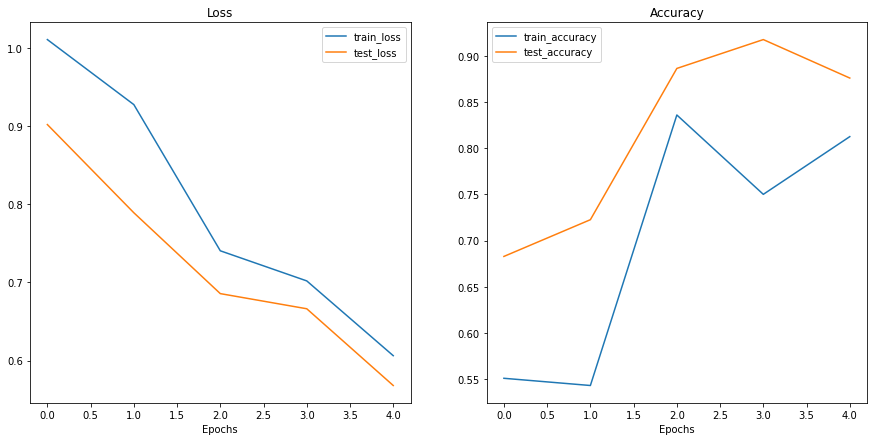

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make prediction on image from the test set

We have to make sure that our test/custom data is:

* Same shape - image need to be same shape as model was trained on.

* Same datatype - custom data should be in the same data type.

* Same device - custom data/test data should be on the same device as the model.

* Same transform - if we've transformed our custom data, ideally we will transform the test data and custom data the same.

To do all of this autometically, let's create a function called `pred_and_plot_image()`.

The following step:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.

2. Open an image with `PIL.Image.open()`.

3. Create a transform for the image (this will default to the manual_transforms we created above or it could use a transform generated from `weights.transforms())`.

4. Make sure the model is on the target device.

5. Turn on model eval mode with `model.eval()` (this turns off layers like nn.Dropout(), so they aren't used for inference) and the inference mode context manager.

6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.

7. Make a prediction on the image by passing it to the model ensuring it's on the target device.

8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.

9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.

10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8.

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

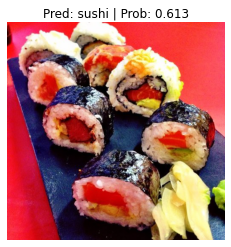

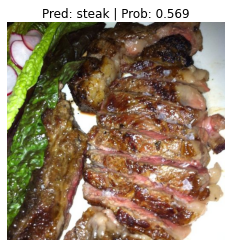

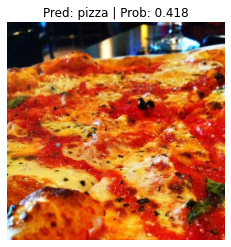

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))